### Homework 3: Linear Model Selection and Regularization
Tianyue Niu

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import statsmodels.api as sm
import itertools

#### Conceptual Exercises

1. (5 points) Generate a data set with p = 20 features, n = 1000 observations, and an associated quantitative response vector generated according to the model Y =Xβ+ε where β has some elements that are exactly equal to zero.

In [2]:
#set random seed
np.random.seed(888)

#generate the data
df = pd.DataFrame() #create pandas data frame
df['Y'] = 0

#simulate beta (drawn from normal distribution, mu/sigma = a random int from 0 to 10)
beta = np.random.normal(np.random.randint(10), np.random.randint(10), 20)
beta = beta.tolist()

#get some random zeros in the betas
beta[5]=0
beta[10]=0
beta[12]=0
beta[17]=0


#simulate X and update Y (drawn from normal distribution, mu/sigma = a random int from 0 to 10)
for i in range(20):
    X = np.random.normal(np.random.randint(10), np.random.randint(10), 1000)
    column = "X{}".format(i+1)
    df[column] = X
    Y = X * beta[i]
    if i == 0:
        df['Y'] = Y
    else:
        df['Y'] = df['Y']+Y

#simulate error term (drawn from normal distribution, mu/sigma = a random int from 0 to 10)
error = np.random.normal(0, np.random.randint(10), 1000)
df['error'] = error

#add error term to Y
df['Y'] = df['Y'] + df['error']

In [3]:
df.head(10)

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,error
0,246.747711,-3.899263,16.696821,4.975336,0.797611,6.861231,2.992552,1.398557,6.963234,23.858665,...,-5.193007,9.0,7.567973,-7.619351,6.317549,7.277377,11.096196,0.830874,-9.255737,1.654127
1,543.463296,-3.961610,10.146065,5.224739,3.348549,12.891143,3.510391,0.715523,11.973041,1.523750,...,8.415727,9.0,6.166661,5.471839,4.952937,-0.059301,-2.534008,-1.475291,2.407758,-0.170649
2,543.482597,-2.479828,27.161215,10.797048,2.647927,8.592427,4.396021,1.579931,6.337978,5.717468,...,9.331063,9.0,7.943897,-1.062119,5.509789,7.416610,-0.609956,3.428818,0.967375,4.513860
3,626.044198,-0.624174,16.328068,7.126836,2.536630,8.634739,6.285267,-0.127068,9.542362,8.006732,...,3.973965,9.0,14.925661,1.975931,6.617723,9.423327,7.921454,-0.840835,4.415255,1.896135
4,470.336713,1.565751,7.251556,9.708258,0.338604,16.346296,7.429801,-0.838364,6.756570,6.365279,...,6.008270,9.0,10.692814,-5.418476,6.465313,14.485206,-6.167487,4.538094,-6.768998,10.903834
5,621.002445,-3.803680,13.885611,7.986706,-0.390849,3.434973,8.874751,-2.577973,10.593255,7.273992,...,3.427828,9.0,9.022258,14.723468,5.641200,12.525967,0.808051,0.615897,13.741705,2.908311
6,414.532263,-0.622173,28.512731,10.281089,3.727853,-4.681738,0.570212,0.167307,8.156818,7.580487,...,5.854213,9.0,7.809580,4.225993,5.024250,-0.470498,5.079171,2.785594,-5.735738,0.930112
7,397.964396,1.868296,1.887677,4.738699,-2.238448,9.598617,-5.525364,-0.581697,11.595701,16.062791,...,5.788965,9.0,6.945622,-14.913019,5.726769,5.261565,3.487462,-0.594030,10.009866,5.720803
8,363.847561,-0.685615,5.193803,5.662380,-0.869027,4.155906,-4.047810,1.159368,7.683500,-10.586342,...,-0.122964,9.0,3.687317,9.955270,5.980294,3.534371,1.893686,1.491292,-2.202277,2.471764
9,210.322755,2.471869,11.999986,8.310086,-1.600441,-0.783752,-8.009199,0.669494,8.561108,-3.080946,...,3.419022,9.0,3.392745,8.407846,5.546805,6.001722,0.180339,-0.063491,-5.210165,-3.454199


2. (10 points) Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [4]:
Xs = ["X{}".format(i+1) for i in range(20)]
predictors = df[Xs]
response = df['Y']

3. (10 points) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size. For which model size does the training set MSE take on its minimum value?

In [5]:
ks = list(range(1,5)) 
#Testing best subset code using k = 1,2,3,4
#because larger ks exceeds my computer's computing power.
#I've also tried running the code on RCC,
#but it never finished running in a reasonable time (1hr).

def best_subset_selection (xtrain, xtest, ytrain, ytest, predictors, response, k, train):

    Xs = None
    best_mse = 100000000
    for each in itertools.combinations(xtrain, k):
        lm = LinearRegression().fit(xtrain[list(each)],ytrain)
        
        if train:
            ypred = lm.predict(xtrain[list(each)])
            mse = mean_squared_error(ytrain, ypred)
            if mse < best_mse:
                best_mse = mse
                Xs = list(each)
            
        else:
            ypred = lm.predict(xtest[list(each)])
            mse = mean_squared_error(ytest, ypred)
            if mse < best_mse:
                best_mse = mse
                Xs = list(each)
                
    return Xs, best_mse

def get_best_mse (xtrain, xtest, ytrain, ytest, predictors, response, ks, train):
    res = []
    for k in ks:
        res.append(best_subset_selection(xtrain, xtest, ytrain, 
                                         ytest, predictors, response, k, train))
    return res

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(predictors, response, test_size=0.9)

In [7]:
mses = get_best_mse(xtrain, xtest, ytrain, ytest, predictors, response, ks, train=True)
mses #MSE monotonically decreases

[(['X2'], 11159.625752852653),
 (['X2', 'X20'], 8751.187400374904),
 (['X2', 'X10', 'X20'], 6541.850827882004),
 (['X2', 'X10', 'X15', 'X20'], 3742.090058278381)]

In [8]:
mses = pd.DataFrame(mses, columns=['predictors', 'mse'])
mses['predictors'] = mses['predictors'].astype(str)

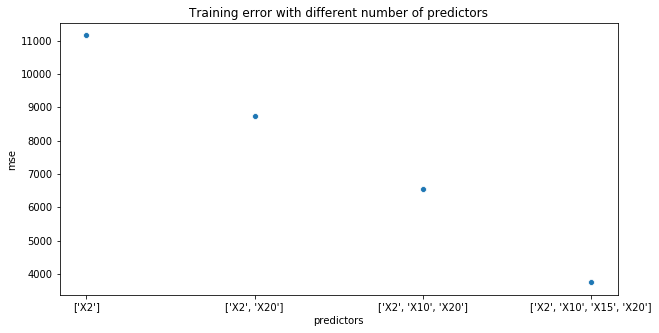

In [9]:
plt.figure(figsize=(10,5))
sb.scatterplot(x='predictors',y='mse',data=mses)
plt.title('Training error with different number of predictors');

The code works, but I'm unable to run 20 choose k ($2^{20}$) using my computer/RCC. 
The following questions use forward selection because given that our Xs were randomly drawn from a normal distribution, they should work the same.

In [10]:
def forward_select(xtrain, ytrain, xtest, ytest):
    
    res = []
    models = []
    for k in range (1,21):
        lm = LinearRegression()
        subset = sfs(lm, k_features=k, forward=True, 
                    scoring ='neg_mean_squared_error', cv=0)
        subset.fit(xtrain, ytrain)
        lm = lm.fit(xtrain[list(subset.k_feature_names_)], ytrain)
        ypred = lm.predict(xtest[list(subset.k_feature_names_)])
        test_mse = mean_squared_error(ytest, ypred)
        res.append([list(subset.k_feature_names_), -subset.k_score_, test_mse])
        models.append(lm)
    
    return res, models

In [11]:
result, models = forward_select(xtrain, ytrain, xtest, ytest)

In [12]:
best_models = pd.DataFrame(result, columns=['predictors', 'train_mse', 'test_mse'])
best_models['no_of_preds'] = range(1,21)
best_models.head(5)

,predictors,train_mse,test_mse,no_of_preds
0,[X2],11159.625753,15150.675629,1
1,"[X2, X20]",8751.187400,12751.490581,2
2,"[X2, X10, X20]",6541.850828,9171.981615,3
3,"[X2, X10, X15, X20]",3742.090058,4488.055403,4
4,"[X2, X5, X10, X15, X20]",1888.453248,2243.265235,5


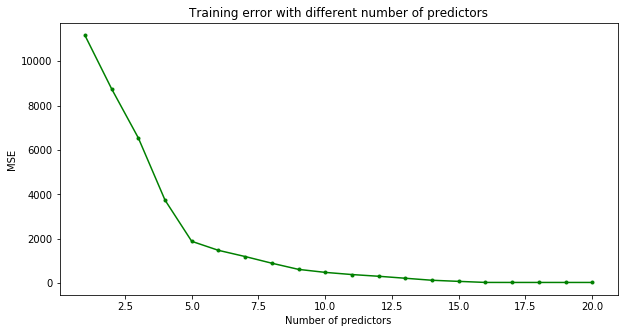

In [13]:
plt.figure(figsize=(10,5))
plt.plot(best_models['no_of_preds'],best_models['train_mse'], marker='.', color='green')
plt.title('Training error with different number of predictors')
plt.xlabel('Number of predictors')
plt.ylabel('MSE');

4. (5 points) Plot the test set MSE associated with the best model of each size.

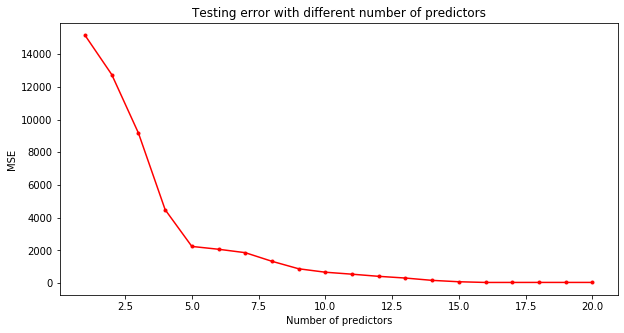

In [14]:
plt.figure(figsize=(10,5))
plt.plot(best_models['no_of_preds'],best_models['test_mse'], marker='.', color='red')
plt.title('Testing error with different number of predictors')
plt.xlabel('Number of predictors')
plt.ylabel('MSE');

5. (5 points) For which model size does the test set MSE take on its minimum value? Comment on your results.  
If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you generate the data previously until you create a data generating process in which the test set MSE is minimized for an intermediate model size.

In [15]:
#get min test_mse
best_models['test_mse'].min()

40.758948432622034

In [16]:
#query to see which row is it
best_models.query('test_mse==40.758948432622034')

,predictors,train_mse,test_mse,no_of_preds
15,"[X1, X2, X3, X4, X5, X7, X8, X9, X10, X12, X14...",38.181972,40.758948,16


In [17]:
print(best_models['predictors'][15])

['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'X8', 'X9', 'X10', 'X12', 'X14', 'X15', 'X16', 'X17', 'X19', 'X20']


Test mse is lowest for the model with 16 predictors printed above. Intuitively, the result is very reasonable because X6, X11, X13, and X18's betas were set to zero. This best performing model has successfully filtered out these four predictors.

6. (10 points) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient sizes.

In [18]:
model_min_mse = models[15]
#print coefficients of our model
coef_model = list(model_min_mse.coef_)
print(coef_model)

[5.639540713564799, 8.435963789420452, 3.4627394821106243, 6.908421337997397, 8.853500343403525, 8.410177708398614, 6.277466319336397, 1.8710561256682434, 8.436885994064559, 5.28926355454798, 2.4092359943115196, 8.814554286867667, 10.113892147667748, 1.498535458011384, 5.937400308677046, 6.926707065409724]


In [19]:
#print true betas
coef_true = list(filter(lambda num: num != 0, beta))
print(coef_true)

[5.601361933044631, 8.349232017980754, 3.387652972402636, 7.121681225467688, 8.810529570762707, 8.478782079472992, 6.348124086150126, 1.8019628167272916, 8.584907324733068, 5.266167681034977, 2.305601794805458, 8.901337186012492, 10.008305328387362, 1.3377266351299806, 5.812968904879149, 7.0090377341267045]


In [20]:
dict_beta = {'Model_Coef':coef_model,'Beta':coef_true}
df_beta = pd.DataFrame(dict_beta)

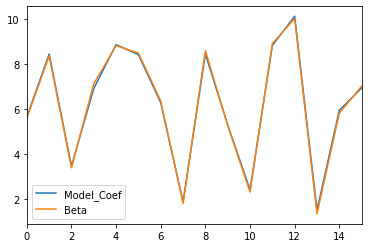

In [21]:
df_beta.plot();

As can be seen from the above graph, our best model's coefficients are very similar to the true betas. 

7. (10 points) Create a plot displaying $\sqrt{\sum_{j=1}^p(\beta_j - \hat{\beta_j^r})^2}$ for a range of values of r, where $\hat{\beta_j^r}$ is the jth coefficient estimate for the best model containing r coefficients. Comment on what you observe. How does this compare to the test MSE plot?

In [28]:
preds = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 
         'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20']

In [29]:
#create a dictionary for predictor:beta
dict_beta = dict(zip(preds, beta)) 

Calculate $\sqrt{\sum_{j=1}^p(\beta_j - \hat{\beta_j^r})^2}$ :

In [59]:
res = []
count_model = 0
for model in models:
    coefs = model.coef_ 
    sum_j = 0    
    for p in preds:
        count_pred = 0
        bj = dict_beta[p]  
        if p not in best_models['predictors'][count_model]:
            bjr = 0        
        else:
            bjr = coefs[count_pred]
            count_pred+=1
        sum_j += (bj - bjr)**2    
    count_model +=1
    res.append(sum_j**(1/2))   

In [60]:
best_models['beta_diff'] = res

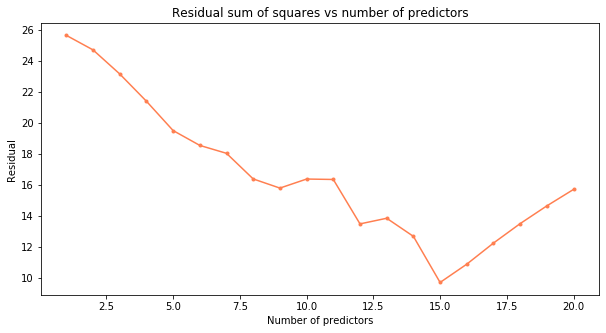

In [65]:
plt.figure(figsize=(10,5))
plt.plot(best_models['no_of_preds'],best_models['beta_diff'], marker='.', color='coral')
plt.title('Residual sum of squares vs number of predictors')
plt.xlabel('Number of predictors')
plt.ylabel('Residual');

The trend of this graph is similar to test MSE, we see that residual decreases as number of predictors increase, and then increases after number of predictors exceed 15. Unlike the test MSE plot, We clearly see in this graph that at number of predictors = 15, the residual is the lowest across models. 

#### Application Exercises 

*Your task is to construct a series of statistical/machine learning models to accurately predict an individual’s egalitarianism using model selection and regularization methods. Use all the available predictors for each model unless otherwise specified.*

In [220]:
gss_train = pd.read_csv('gss_train.csv')
gss_test = pd.read_csv('gss_test.csv')

1. (10 points) Fit a least squares linear model on the training set, and report the test MSE.

In [221]:
y_train = gss_train['egalit_scale']
y_test = gss_test['egalit_scale']
x_train = gss_train.drop('egalit_scale', axis=1)
x_test = gss_test.drop('egalit_scale', axis=1)

In [222]:
lm = LinearRegression().fit(x_train,y_train)
ypred =lm.predict(x_test)

In [223]:
mse = mean_squared_error(y_test, ypred)
print("Test MSE for linaer regression is:", mse)

Test MSE for linaer regression is: 63.21362962301499


2. (10 points) Fit a ridge regression model on the training set, with λ chosen by 10-fold cross-validation.
Report the test MSE.

In [224]:
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10, 50, 100], cv=10).fit(x_train, y_train)

In [225]:
print("Test MSE for ridge is:", mean_squared_error(y_test, ridge.predict(x_test)))

Test MSE for ridge is: 62.25641082226911


In [226]:
ridge.score(x_train, y_train)

0.3910106286999935

3. (10 points) Fit a lasso regression on the training set, with λ chosen by 10-fold cross-validation. Report the test MSE, along with the number of non-zero coefficient estimates.

In [227]:
lasso = LassoCV(alphas=[0.01, 0.1, 1.0, 10, 50, 100], cv=10).fit(x_train, y_train)

In [228]:
print("Test MSE is for lasso:", mean_squared_error(y_test, lasso.predict(x_test)))

Test MSE is for lasso: 62.77841555477389


In [229]:
print("Number of non-zero coefficients for lasso regression = ", (lasso.coef_ != 0).sum())

Number of non-zero coefficients for lasso regression =  24


In [230]:
lasso.score(x_train, y_train)

0.38161120285798467

4. (10 points) Fit an elastic net regression model on the training set, with α and λ chosen by 10-fold cross-validation. That is, estimate models with α = 0, 0.1, 0.2, . . . , 1 using the same values for λ across each model. Select the combination of α and λ with the lowest cross-validation MSE. For that combination, report the test MSE along with the number of non-zero coefficient estimates.

In [216]:
elastic = ElasticNetCV(l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                       cv=10).fit(x_train, y_train)

In [231]:
print("Test MSE for elastic is:", mean_squared_error(y_test, elastic.predict(x_test)))

Test MSE for elastic is: 62.7780157899344


In [232]:
print("Number of non-zero coefficients for elastic net regreesion = ", 
      np.array([elastic.coef_ != 0]).sum())

Number of non-zero coefficients for elastic net regreesion =  24


In [233]:
elastic.score(x_train, y_train)

0.3816218146011686

5. (5 points) Comment on the results obtained. How accurately can we predict an individual’s egalitarian- ism? Is there much difference among the test errors resulting from these approaches?

Thre really isn't much difference between the three different regressions in terms of MSE and accuracy. All three model's test MSE is around 62, which is also not that different from the result of a non-regularized linear regression. In general, we are not predicting individual's egalitarianism very well (training accuracy is less than .40 for all three regularized models). To obtain a higher accuracy we would probably need to change our model entirely to something other than linear regression. 